### Using GAN for Faces Images Generation

#### Download and Extract the Dataset

In [1]:
#! wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip

In [2]:
#! unzip male_female_face_images.zip

#### Import the Relevant Packages

In [3]:
from torch_snippets import *
from torchvision import transforms as T
from glob import glob
from PIL import Image
import torchvision
import torch.nn as nn
import torchvision.utils as vutils
import cv2 , numpy as np , pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Crop the Images to Contain only Faces

In [4]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [5]:
! mkdir cropped_images

mkdir: cannot create directory ‘cropped_images’: File exists


In [6]:
images_paths = glob('males/*.jpg') + glob('females/*.jpg')

In [7]:
for i in range(len(images_paths)):
    image = cv2.imread(images_paths[i],1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        cropped_image = image[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_images/'+str(i)+'.jpg',cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))


#### Define the Dataset and Dataloader

In [8]:
transform = T.Compose([
                        T.Resize(64),
                        T.CenterCrop(64),
                        T.ToTensor(),
                        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [9]:
class Faces(Dataset):

    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(glob(self.folder + '/*.jpg'))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        image = transform(image)
        
        return image

In [10]:
faces_dataset = Faces(folder = "cropped_images")

In [11]:
faces_dataloader = DataLoader(faces_dataset, batch_size=64, shuffle=True , num_workers=8)

#### Define the Weight Initialization

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### Define the Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Convolutional layers
        self.model = nn.Sequential(
                                   nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                                   nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64*2,64*4,4,2,1,bias=False),
                                   nn.BatchNorm2d(64*4),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Conv2d(64*4,64*8,4,2,1,bias=False),
                                   nn.BatchNorm2d(64*8),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Conv2d(64*8,1,4,1,0,bias=False),
                                   nn.Sigmoid()
                                   )
        self.apply(weights_init)
    def forward(self, input):
        return self.model(input)


In [14]:
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

#### Defined the Generator

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                                    nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
                                    nn.BatchNorm2d(64*8),
                                    nn.ReLU(True),
                                    nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
                                    nn.BatchNorm2d(64*4),
                                    nn.ReLU(True),
                                    nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
                                    nn.BatchNorm2d(64*2),
                                    nn.ReLU(True),
                                    nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(True),
                                    nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
                                    nn.Tanh()
                                         )
        self.apply(weights_init)
    def forward(self, input):
        output = self.model(input)
        return output

In [16]:
generator = Generator().to(device)
summary(generator, input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

#### Define functions to Train the Discriminator and Generator, Optimizers, and Loss Function 

In [17]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()
def discriminator_train_step(real_images, fake_images):
    discriminator_optimizer.zero_grad()
    pred_real = discriminator(real_images)
    pred_fake = discriminator(fake_images)
    loss_real = loss(pred_real.squeeze(), torch.ones(len(real_images)).to(device)).to(device)
    loss_real.backward()
    loss_fake = loss(pred_fake.squeeze(), torch.zeros(len(fake_images)).to(device)).to(device)
    loss_fake.backward()
    discriminator_optimizer.step()
    return loss_real + loss_fake

In [18]:
def generator_train_step(fake_images):
    generator_optimizer.zero_grad()
    pred = discriminator(fake_images)
    error  = loss(pred.squeeze(), torch.ones(len(fake_images)).to(device)).to(device)
    error.backward()
    generator_optimizer.step()
    return error

#### Run the models over Increasing Epochs

EPOCH: 1.000  g_loss: 5.722  d_loss: 0.248  (37.09s - 1075.53s remaining))
EPOCH: 2.000  g_loss: 5.474  d_loss: 0.270  (74.57s - 1044.04s remaining))
EPOCH: 3.000  g_loss: 5.706  d_loss: 0.266  (112.25s - 1010.23s remaining))
EPOCH: 4.000  g_loss: 5.332  d_loss: 0.241  (150.07s - 975.47s remaining))
EPOCH: 5.000  g_loss: 5.531  d_loss: 0.241  (188.00s - 940.00s remaining))
EPOCH: 6.000  g_loss: 5.672  d_loss: 0.258  (226.02s - 904.07s remaining))
EPOCH: 7.000  g_loss: 5.530  d_loss: 0.273  (264.07s - 867.66s remaining))
EPOCH: 8.000  g_loss: 5.473  d_loss: 0.245  (302.12s - 830.82s remaining))
EPOCH: 9.000  g_loss: 5.532  d_loss: 0.253  (340.13s - 793.65s remaining))
EPOCH: 10.000  g_loss: 5.480  d_loss: 0.247  (378.20s - 756.41s remaining)
EPOCH: 11.000  g_loss: 5.517  d_loss: 0.247  (416.30s - 719.07s remaining))
EPOCH: 12.000  g_loss: 5.529  d_loss: 0.279  (454.41s - 681.61s remaining)
EPOCH: 13.000  g_loss: 5.463  d_loss: 0.278  (492.54s - 644.10s remaining)
EPOCH: 14.000  g_loss: 

100%|██████████| 131/131 [00:00<00:00, 337.40it/s]


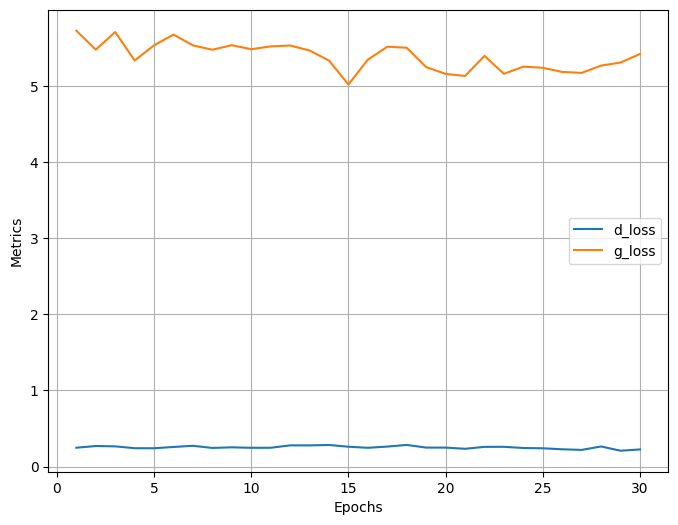

In [21]:
log = Report(30)
for epoch in range (30):
    N = len(faces_dataloader)
    for i, images in enumerate(faces_dataloader):
        real_images = images.to(device)
        fake_images = fake_data = generator(torch.randn(len(real_images), 100, 1, 1).to(device)).to(device)
        fake_images = fake_images.detach()
        d_loss = discriminator_train_step(real_images, fake_images)
        fake_images = fake_data = generator(torch.randn(len(real_images), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_images)

        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])